In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import os
import subprocess
import sys
import matplotlib.pyplot as plt
from IPython import display

To view this notebook as slides, run `jupyter nbconvert Tutorial.ipynb --to slides --post serve` on the command line

Run this in Binder
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/KTH-dESA/esom_gsa/envs?labpath=Tutorial.ipynb)

# ECEMP Skills Workshop: Global Sensitivity Analysis

- Will Usher, KTH Royal Institute of Technology
- Trevor Barnes, Simon Fraser University

## Publication 

The work in this notebook is a summary of the following open-access paper:

> Usher W, Barnes T, Moksnes N and Niet T. Global sensitivity analysis to enhance the transparency and rigour of energy system optimisation modelling [version 1; peer review: 1 approved, 2 approved with reservations]. Open Res Europe 2023, 3:30 (https://doi.org/10.12688/openreseurope.15461.1)

# Introduction

## What is global sensitivity analysis?

- Global sensitivity analysis is “*the study of how uncertainty in the output of a model...can be apportioned to different sources of uncertainty in the model input*”. 
- “Global” means that all parameters are moved over their input ranges at the same time.
- By contrast, in one-at-a-time (OAT) sensitivity analysis, only one dimension of the model input space is explored while holding all other dimensions at their central value.
- An excellent introduction to global sensitivity analysis can be found in Saltelli (2007).

## Why perform global sensitivity analysis?

- Most energy system optimisation modelling studies use scenario analysis
- Global sensitivity analysis can supplement and support scenario analysis
  - identify key drivers of model results (factor prioritisation)
  - identify unimportant parameters (factor fixing)
  - identify interesting areas of the input space (factor mapping)

## Methods for conducting global sensitivity analysis

Variance-based approaches compute the proportion of the variance in the output that is explained by variation in the input. 

- Computation of a first-order (only the direct effect) and total-order (direct and interaction effects) index for each input recovers all interaction and non-linear effects of a model. 
- Variance-based approaches require a relatively large number $(500(k+2))$ of model runs.

Elementary effects test, or “Method of Morris” lowers computationally needs $(10(k+1))$ by computing an average of local derivatives over a discrete space of input parameters.

- It provides an estimate for the total-order index produced by more advanced variance-based approaches 
- can be applied to groups of inputs to increase coverage and reduce computational demands.

## Tools for performing global sensitivity analyses

The Python library [SALib](http://salib.github.io/SALib/) provides implementations of powerful global sensitivity analysis approaches.


-   Sobol Sensitivity Analysis ([Sobol
    2001](http://www.sciencedirect.com/science/article/pii/S0378475400002706), [Saltelli
    2002](http://www.sciencedirect.com/science/article/pii/S0010465502002801), [Saltelli et al.
    2010](http://www.sciencedirect.com/science/article/pii/S0010465509003087))

-   Method of Morris, including groups and optimal trajectories ([Morris
    1991](http://www.tandfonline.com/doi/abs/10.1080/00401706.1991.10484804), [Campolongo et al.
    2007](http://www.sciencedirect.com/science/article/pii/S1364815206002805))

-   Fourier Amplitude Sensitivity Test (FAST) ([Cukier et al.
    1973](http://scitation.aip.org/content/aip/journal/jcp/59/8/10.1063/1.1680571), [Saltelli et al.
    1999](http://amstat.tandfonline.com/doi/abs/10.1080/00401706.1999.10485594))

-   Random Balance Designs - Fourier Amplitude Sensitivity Test
    (RBD-FAST) ([Tarantola et al.
    2006](https://hal.archives-ouvertes.fr/hal-01065897/file/Tarantola06RESS_HAL.pdf), [Elmar Plischke
    2010](https://doi.org/10.1016/j.ress.2009.11.005), [Tissot et al.
    2012](https://doi.org/10.1016/j.ress.2012.06.010))

-   Delta Moment-Independent Measure ([Borgonovo
    2007](http://www.sciencedirect.com/science/article/pii/S0951832006000883), [Plischke et al.
    2013](http://www.sciencedirect.com/science/article/pii/S0377221712008995))

-   Derivative-based Global Sensitivity Measure (DGSM) ([Sobol and
    Kucherenko
    2009](http://www.sciencedirect.com/science/article/pii/S0378475409000354))

-   Fractional Factorial Sensitivity Analysis ([Saltelli et al.
    2008](http://www.wiley.com/WileyCDA/WileyTitle/productCd-0470059974.html))

-   High Dimensional Model Representation ([Li et al.
    2010](https://pubs.acs.org/doi/pdf/10.1021/jp9096919))
    
   

In [2]:
from SALib import ProblemSpec
from SALib.test_functions import Ishigami

To use the SALib libary, you first define a `ProblemSpec` containing the names and bounds of your variables.

In [3]:
# By convention, we assign to "sp" (for "SALib Problem")
sp = ProblemSpec({
  'names': ['x1', 'x2', 'x3'],    # Name of each parameter
  'bounds': [[-np.pi, np.pi]]*3,  # bounds of each parameter
  'outputs': ['Y']                # name of outputs in expected order
})

Then you create a sample using the method of your choice.

In [4]:
# Create the sample
sp = sp.sample_saltelli(1024, calc_second_order=True)

You run your model many times, once for each row of the sample.

In [5]:
# Run the model
sp = sp.evaluate(Ishigami.evaluate)

Finally, you run the matching analysis method for each model output you wish to perform the global sensitivity analysis.

In [6]:
# Run the analysis method
sp = sp.analyze_sobol(print_to_console=False)

In [7]:
# Samples, model results and analyses can be extracted from the ProblemSpec
print(sp)

Samples:
	3 parameters: ['x1', 'x2', 'x3']
	8192 evaluations
Outputs:
	1 outputs: ['Y']
	8192 evaluations
Analysis:
          ST   ST_conf
x1  0.555860  0.089585
x2  0.441898  0.038814
x3  0.244675  0.024909
          S1   S1_conf
x1  0.316832  0.066560
x2  0.443763  0.050831
x3  0.012203  0.056553
                S2   S2_conf
(x1, x2)  0.009254  0.096677
(x1, x3)  0.238172  0.106488
(x2, x3) -0.004888  0.060814



array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

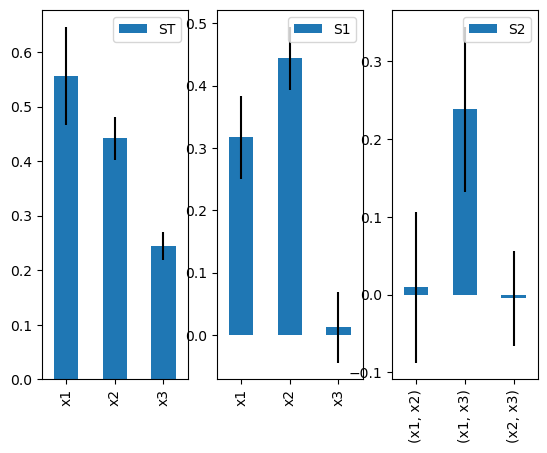

In [8]:
# Basic plotting functionality is also provided
sp.plot()

Samples:
	3 parameters: ['x1', 'x2', 'x3']
	40 evaluations
Outputs:
	1 outputs: ['Y']
	40 evaluations
Analysis:
           mu    mu_star     sigma  mu_star_conf
x1  10.203573  10.203573  6.036911  2.984802e+00
x2   0.000000   7.875000  8.300979  3.499135e-15
x3  -1.249759   1.249759  3.952086  2.176870e+00



<Axes: >

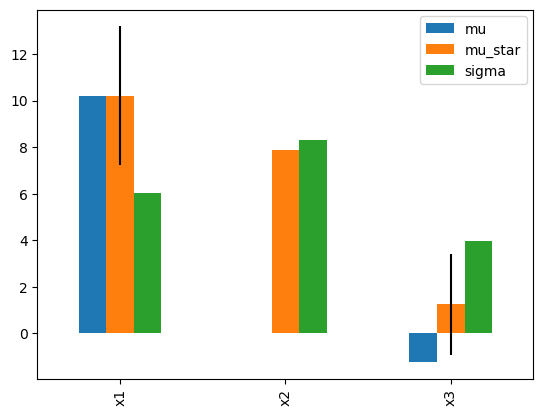

In [9]:
from SALib import ProblemSpec
from SALib.test_functions import Ishigami

# By convention, we assign to "sp" (for "SALib Problem")
sp = ProblemSpec({
  'names': ['x1', 'x2', 'x3'],    # Name of each parameter
  'bounds': [[-np.pi, np.pi]]*3,  # bounds of each parameter
  'outputs': ['Y']                # name of outputs in expected order
})

# Create the sample
sp.sample_morris(100, optimal_trajectories=10, local_optimization=True, num_levels=4)

# Run the model
sp.evaluate(Ishigami.evaluate)

# Run the matching analysis method
sp.analyze_morris(print_to_console=False)

# Samples, model results and analyses can be extracted:
print(sp)

# Basic plotting functionality is also provided
sp.plot()

# References

Andrea Saltelli, Marco Ratto, Terry Andres, Francesca Campolongo, Jessica Cariboni, Debora Gatelli, Michaela Saisana, and Stefano Tarantola. Global Sensitivity Analysis. The Primer. 1st ed. John Wiley & Sons, Ltd, 2007. [doi:10.1002/9780470725184](https://doi.org/10.1002/9780470725184).

Iwanaga, T., Usher, W., & Herman, J. (2022). Toward SALib 2.0: Advancing the accessibility and interpretability of global sensitivity analyses. Socio-Environmental Systems Modelling, 4, 18155. [doi:10.18174/sesmo.18155](https://doi.org/10.21105/joss.00097)

Herman, J. and Usher, W. (2017) SALib: An open-source Python library for sensitivity analysis. Journal of Open Source Software, 2(9). [doi:10.21105/joss.00097](https://doi.org/10.21105/joss.00097)

# Example One

In this example, we will first show build a simple model and perform 
**LOCAL** sensitivity analysis

## Reference Energy System

Consider the simple energy system optimization model below. It includes: 

- A mining technology to introduce uranium 
- A nuclear power generation technology
- Uranium fuel
- Electricity fuel

![RES](./examples/figures/res.jpg)

## Input Data

We will add data for: 
- Capital Costs
- Fixed Costs
- Variable Costs (including fuel costs)
- Powerplant Efficiency 
- Powerplant Operational Life 
- Electricity Demand 

The model will be run given the assumptions: 
- Model horizon of 50 years 
- 8 equal time slices per year
- Linearly increasing yearly demand

### Helper Functions 

In [10]:
def make_set(data, save):
    df = pd.DataFrame(data={"VALUE":data})
    df.to_csv(save, index=False)

In [11]:
def make_param(data, param_value, save=None):
    df = pd.DataFrame(data=data)
    for col in data.keys():
        df = df.explode(column=col)
    df = df.reset_index(drop=True)
    df["VALUE"] = param_value
    if save:
        df.to_csv(save, index=False)
    return df

In [12]:
example_dir = Path('./examples/1/')
data_dir = Path(example_dir, "data")
if not data_dir.exists():
    data_dir.mkdir()

#### Create Template Data

In [13]:
subprocess.check_output(["otoole", "setup", "csv", str(Path(data_dir)), "--overwrite"])

b''

### Create Data

In [14]:
years = range(2020, 2071)
make_set(years, str(Path(data_dir, "YEAR.csv")))
techs = ['MINE_URANIUM', 'NUCLEAR']
make_set(techs, str(Path(data_dir, "TECHNOLOGY.csv")))
fuels = ['URANIUM', 'ELECTRICITY']
make_set(fuels, str(Path(data_dir, "FUEL.csv")))
regions = ['R1']
make_set(regions, str(Path(data_dir, "REGION.csv")))
ts = ['S1D1', 'S1D2', 'S2D1', 'S2D2','S3D1','S3D2','S4D1','S4D2']
make_set(ts, str(Path(data_dir, "TIMESLICE.csv")))
modes = [1]
make_set(modes, str(Path(data_dir, "MODE_OF_OPERATION.csv")))

#### Add Capital Costs

In [15]:
capex = 4000 # M$ / GW
capex_indices = {
    "REGION": [regions],
    "TECHNOLOGY": ["NUCLEAR"],
    "YEAR": [years]
}
make_param(capex_indices, capex, str(Path(data_dir, "CapitalCost.csv"))).head()

,REGION,TECHNOLOGY,YEAR,VALUE
0,R1,NUCLEAR,2020,4000
1,R1,NUCLEAR,2021,4000
2,R1,NUCLEAR,2022,4000
3,R1,NUCLEAR,2023,4000
4,R1,NUCLEAR,2024,4000


#### Add Fixed Operational Costs

In [16]:
fixed = 50 # M$ / GW
fixed_indices = {
    "REGION": [regions],
    "TECHNOLOGY": ["NUCLEAR"],
    "YEAR": [years]
}
make_param(fixed_indices, fixed, str(Path(data_dir, "FixedCost.csv"))).head()

,REGION,TECHNOLOGY,YEAR,VALUE
0,R1,NUCLEAR,2020,50
1,R1,NUCLEAR,2021,50
2,R1,NUCLEAR,2022,50
3,R1,NUCLEAR,2023,50
4,R1,NUCLEAR,2024,50


#### Add Variable Costs

In [17]:
variable = 2.5 # M$ / PJ
variable_indices = {
    "REGION": [regions],
    "TECHNOLOGY": ["MINE_URANIUM"],
    "MODE_OF_OPERATION": [modes],
    "YEAR": [years]
}
make_param(variable_indices, variable, str(Path(data_dir, "VariableCost.csv"))).head()

,REGION,TECHNOLOGY,MODE_OF_OPERATION,YEAR,VALUE
0,R1,MINE_URANIUM,1,2020,2.5
1,R1,MINE_URANIUM,1,2021,2.5
2,R1,MINE_URANIUM,1,2022,2.5
3,R1,MINE_URANIUM,1,2023,2.5
4,R1,MINE_URANIUM,1,2024,2.5


#### Add Nuclear Power Plant Efficiency 

In [18]:
eff = 1.25 # 80 %
eff_indices = {
    "REGION": [regions],
    "TECHNOLOGY": ["NUCLEAR"],
    "FUEL": ["URANIUM"],
    "MODE_OF_OPERATION": [modes],
    "YEAR": [years]
}
make_param(eff_indices, eff, str(Path(data_dir, "InputActivityRatio.csv"))).head()

,REGION,TECHNOLOGY,FUEL,MODE_OF_OPERATION,YEAR,VALUE
0,R1,NUCLEAR,URANIUM,1,2020,1.25
1,R1,NUCLEAR,URANIUM,1,2021,1.25
2,R1,NUCLEAR,URANIUM,1,2022,1.25
3,R1,NUCLEAR,URANIUM,1,2023,1.25
4,R1,NUCLEAR,URANIUM,1,2024,1.25


#### Add Demand

In [19]:
def add_demand(start_value, yearly_increase, years, region, fuel, save):
    demand_data = []
    for year in years:
        demand_data.append([region, fuel, year, start_value*(1+yearly_increase)**(year-years[0])])
    df = pd.DataFrame(demand_data, columns=['REGION','FUEL','YEAR','VALUE'])
    df.to_csv(Path(data_dir, "SpecifiedAnnualDemand.csv"), index=False)
    return df

In [20]:
start_value = 1000 # PJ
yearly_increase = 0.05 # %
add_demand(start_value, yearly_increase, years, regions[0], "ELECTRICITY", data_dir).head()

,REGION,FUEL,YEAR,VALUE
0,R1,ELECTRICITY,2020,1000.00000
1,R1,ELECTRICITY,2021,1050.00000
2,R1,ELECTRICITY,2022,1102.50000
3,R1,ELECTRICITY,2023,1157.62500
4,R1,ELECTRICITY,2024,1215.50625


### Add Operational Life

In [21]:
op_life = 50 # years
op_life_indices = {
    "REGION": [regions],
    "TECHNOLOGY": ["NUCLEAR"],
}
make_param(op_life_indices, op_life, str(Path(data_dir, "OperationalLife.csv"))).head()

,REGION,TECHNOLOGY,VALUE
0,R1,NUCLEAR,50


#### Add remaining parameters for model setup 

In [22]:
oar = 1
oar_indices = {
    "REGION": [regions],
    "TECHNOLOGY": ["NUCLEAR"],
    "FUEL": ["ELECTRICITY"],
    "MODE_OF_OPERATION": [modes],
    "YEAR": [years]
}
df_1 = make_param(oar_indices, oar)

oar_indices = {
    "REGION": [regions],
    "TECHNOLOGY": ["MINE_URANIUM"],
    "FUEL": ["URANIUM"],
    "MODE_OF_OPERATION": [modes],
    "YEAR": [years]
}
df_2 = make_param(oar_indices, oar)

df = pd.concat([df_1, df_2])
df.to_csv(Path(data_dir, "OutputActivityRatio.csv"), index=False)

In [23]:
demand_profile = 0.125
demand_profile_indices = {
    "REGION": [regions],
    "FUEL": ["ELECTRICITY"],
    "TIMESLICE": [ts],
    "YEAR": [years]
}
make_param(demand_profile_indices, demand_profile, str(Path(data_dir, "SpecifiedDemandProfile.csv"))).head()

,REGION,FUEL,TIMESLICE,YEAR,VALUE
0,R1,ELECTRICITY,S1D1,2020,0.125
1,R1,ELECTRICITY,S1D1,2021,0.125
2,R1,ELECTRICITY,S1D1,2022,0.125
3,R1,ELECTRICITY,S1D1,2023,0.125
4,R1,ELECTRICITY,S1D1,2024,0.125


In [24]:
cap_to_activity = 31.536
cap_to_activity_indices = {
    "REGION": [regions],
    "TECHNOLOGY": [techs],
}
make_param(cap_to_activity_indices, cap_to_activity, str(Path(data_dir, "CapacityToActivityUnit.csv")))

,REGION,TECHNOLOGY,VALUE
0,R1,MINE_URANIUM,31.536
1,R1,NUCLEAR,31.536


## One-at-a-time Sensitivity Analysis
Run the model with the baseline input parameters and get a reference objective value

In [25]:
def run_model(example_dir, path_to_csv, path_to_config, path_to_model, result_file):
    
    subprocess.check_output(
        [
            "otoole", "convert", "csv", "datafile", 
            str(Path(path_to_csv)), str(Path(example_dir, "data.txt")), str(Path(path_to_config))
        ])

    subprocess.check_output(
        [
            "glpsol", 
            "-m", str(Path(path_to_model)), 
            "-d", str(Path(example_dir, "data.txt")), 
            "--wlp", str(Path(example_dir, "model.lp")), "--check"
        ])
    subprocess.check_output(
        [
            "cbc", str(Path(example_dir, "model.lp")), "solve", 
            "-solu", str(Path(example_dir, result_file))
        ])

def get_objective_value(result_files):
    for result_file in result_files:
        print(f"{result_file.name}")
        os.system(f"head -1 {str(Path(example_dir, result_file))}")

In [27]:
run_model(example_dir, data_dir, Path(example_dir, "otoole.yaml"), Path(example_dir, "osemosys.txt"), "base.sol")
get_objective_value([Path("base.sol")])

base.sol
Optimal - objective value 571911.78404130


## Model Results

Solving the model for total discounted costs produces an objective value  of `$572,721,000,000`. In local sensitivity analysis, we select a single parameter to alter and rerun the model. This will tell us the effect that single parameter has on the results around the optimal location. 

### Parameter Changes

We will change both the **capital costs** and **variable costs** of the nuclear power plant to see how sensitive the results are to these parameters. We will do 5 additional runs for each parameter, resulting in 10 total runs. This summary of model runs and results are given below.  

 Run      | Capital Costs (M\$/GW) | Variable Costs (M\$/PJ) | Objective Cost (M$)
:---|---:|---:|---:
 Original | 4000                  | 2.5                   | 571911              
 1        | 2500                  | 2.5                   | 445361              
 2        | 3000                  | 2.5                   | 487545              
 3        | 3500                  | 2.5                   | 529728              
 4        | 4500                  | 2.5                   | 614095              
 5        | 5000                  | 2.5                   | 656278              
 6        | 4000                  | 1.5                   | 509698              
 7        | 4000                  | 2.0                   | 540804              
 8        | 4000                  | 3.0                   | 603018              
 9        | 4000                  | 3.5                   | 634125              
 10       | 4000                  | 4.0                   | 665232              

In [29]:
result_files = []

# Iterate over capital cost
capital_costs = [2500, 3000, 3500, 4500, 5000]
for capital_cost in capital_costs:
    make_param(capex_indices, capital_cost, str(Path(data_dir, "CapitalCost.csv")))
    result_file = f"capex_{capital_cost}.txt"
    result_files.append(Path(result_file))
    run_model(example_dir, data_dir, str(Path(example_dir, "otoole.yaml")), str(Path(example_dir, "osemosys.txt")), result_file)

# resest to original capital cost
make_param(capex_indices, 4000, str(Path(data_dir, "CapitalCost.csv")))

# Iterate over variable cost
var_costs = [1.5, 2.0, 3.0, 3.5, 4.0]
for var_cost in var_costs:
    make_param(variable_indices, var_cost, str(Path(data_dir, "VariableCost.csv")))
    result_file = f"var_cost_{var_cost}.txt"
    result_files.append(Path(result_file))
    run_model(example_dir, data_dir, str(Path(example_dir, "otoole.yaml")), str(Path(example_dir, "osemosys.txt")), result_file)

# reset to original variable cost
make_param(variable_indices, 2.5, str(Path(data_dir, "VariableCost.csv")))

# extract objective costs
get_objective_value(result_files)

capex_2500.txt
Optimal - objective value 445361.88647474
capex_3000.txt
Optimal - objective value 487545.18566359
capex_3500.txt
Optimal - objective value 529728.48485245
capex_4500.txt
Optimal - objective value 614095.08323016
capex_5000.txt
Optimal - objective value 656278.38241901
var_cost_1.5.txt
Optimal - objective value 509698.13682009
var_cost_2.0.txt
Optimal - objective value 540804.96043070
var_cost_3.0.txt
Optimal - objective value 603018.60765191
var_cost_3.5.txt
Optimal - objective value 634125.43126251
var_cost_4.0.txt
Optimal - objective value 665232.25487312


Create simple plots to see how the costs change with parameters

In [30]:
def plot_LSA(df_capex, df_var):
    _, axs = plt.subplots(1,2, figsize=(14,5), sharey=True)
    df_capex.plot(ax=axs[0], marker='o', title='Effects of Capital Cost', xlabel='Capital Cost (M$/GW)', ylabel='Objective Cost (M$)')
    df_var.plot(ax=axs[1], marker='o', title='Effects of Variable Cost', xlabel='Variable Cost (M$/PJ)', ylabel='Objective Cost (M$)')

In [31]:
df_capex = pd.DataFrame([
    [2500, 445361],
    [3000, 487545],
    [3500, 529728],
    [4000, 571911],
    [4500, 614095],
    [5000, 656278],
], columns=['Capex', 'Objective_Cost']).set_index('Capex')

df_var = pd.DataFrame([
    [1.5, 509698],
    [2.0, 540804],
    [2.5, 571911],
    [3.0, 603018],
    [3.5, 634125],
    [4.0, 665232],
], columns=['Var_Cost', 'Objective_Cost']).set_index('Var_Cost')

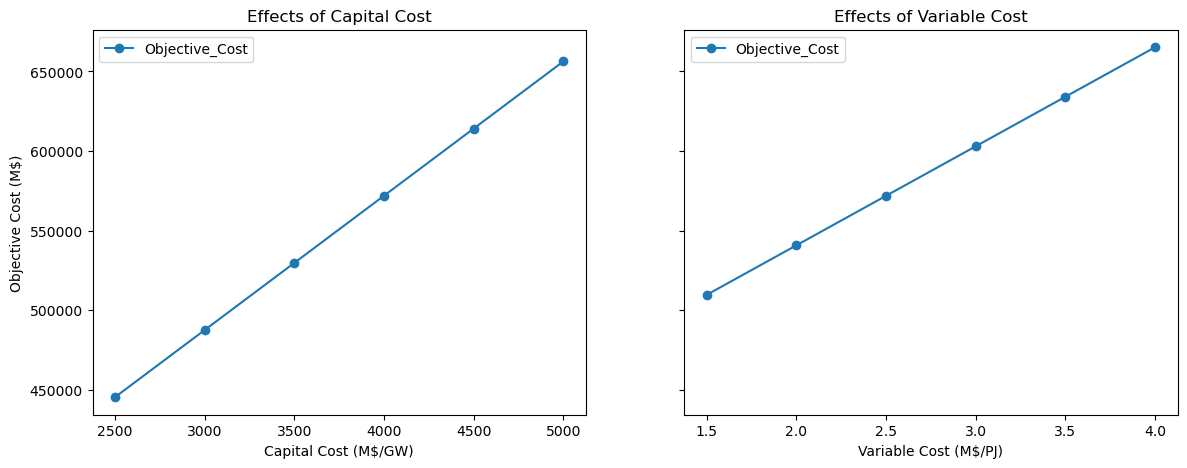

In [32]:
plot_LSA(df_capex, df_var)

## Disadvantages of local sensitivity analysis

A local sensitivity analysis has several weaknesses.  These include the following.

### Limited insights into the influence of parameters

The steeper gradiant of the capital cost plot shows this is the more influential parameter over our range of values. As we add more parameters and build more complex models, viewing the gradient will become impractical. 

### Missing interaction effects

This example also shows a relatively linear response between our variables and value of the objective function. While non-linear effects may be identified by this method, interaction effects would not be. As discussed later, variable costs (which include fuel cost) and the efficiency of the power plant will interact. We do not see this interaction through local sensitivity analysis.

### Computational expense

This approach is inefficient as we need to run one model run per parameter per step.

# Example Two 

We will repeat example one, except employ **GLOBAL** sensitivity analysis using the Method of Morris.

## Reference Energy Systen

Our RES and included parameters will remain the same as example 1. 

![RES](./examples/figures/res.jpg)

## The Workflow

Performing global sensitivity analysis requires running the model many times and careful handling of the results. Therefore, it is beneficial to set up an automated workflow to reduce data handling errors. To execute the workflow, three main steps are required. 

1. Modify the configuration file
2. Run the workflow 
3. Interpret the results

A high-level graphical overview of the the workflow is given below. 


![workflow](./examples/figures/workflow.jpg)


## The Configuration File

The configuration file contains parameters that define how the sensitivity analysis will be conducted. For each factor we want to test, we can test its sensitivity independently of time. Moreover, if the parameter is defined over time (such as a yearly changing demand), we can also test the sensitivity dependent on time. 

### Time Independent Factors 

The figure below highlights the two different options for time-independent factors that can be configured in the workflow. The red lines prepresent the user-entered bounds, while the green lines represent the modelled values. 

![gsa-options](./examples/figures/gsa_options_fixed.jpg)


### Option One

We specify a fixed start point. This results in **no sensitivity analysis** being performed, because we are not varying the parameter over different model runs. 

### Option Two

We specify a moving start point, represented by the red bars. This can be beneficial in situations where we know the parameter value will not change throughout the model run, but want to test the sensitivity of this fixed value. For example, the operational life of a powerplant. 

### Time Dependent Factors 

The figure below highlights three different options for time-dependent factors that can be configured in the workflow. The red lines represent the user-entered bounds, while the green lines represent the interpolated values. 

![gsa-options](./examples/figures/gsa_options_interpolate.jpg)


### Option One

We specify fixed start and end points. This results in **no sensitivity analysis** being performed, because we are not varying the parameter over different model runs. 

### Option Two

We specify a fixed start point, and a moving end point. This can be beneficial in scenario where we know the starting value, but are uncertain about how the value will change in time. For example, the annual demand of our start year may be a known value, but we are uncertain how this will progress throughout the model horizon.
Note that we currently interpolate linearly between the two points but this could include different shapes in the future.

### Option Three

We specify moving start and end points. This is appropriate to test the sensitivity of values when uncertain of both current and future values. For example, fuel costs are always changing, and testing the sensitivity of these changes on your model may be important.

### Modify the Configuration File

Navigate to [`examples/2/parameters.csv`](./examples/2/parameters.csv) file and add sensitivity parameters for the `CapitalCost`, `VariableCost`, and `InputActivityRatio` (defined as 1/efficiency). The formatted parameter csv should look similar to the following. The `interpolation_index` value is either `fixed` or `interpolate` for time independent and time dependent parameters respectively. 

Feel free to user your own values for the min/max values!

|name |group|indexes|min_value_base_year|max_value_base_year|min_value_end_year|max_value_end_year|dist|interpolation_index|action|
|-----|-----|-------|-------------------|-------------------|------------------|------------------|----|-------------------|------|
|CapitalCost  |capital  |"R1,NUCLEAR"        |4000 |5000 |2000 |3000 |"unif" |"YEAR" |"interpolate" |
|VariableCost |variable |"R1,MINE_URANIUM,1" |3.5  |4.0  |1.5  |1.75 |"unif" |"YEAR" |"interpolate" |
|InputActivityRatio | IAR |"R1,NUCLEAR,URANIUM,1" |1.3 | 1.5 | 1.05 | 1.2 | "unif" | "YEAR" | "interpolate" |

### Run the Workflow

Once we have defined our sensitivity parameters, we can run the workflow

In [49]:
!cp -r ./examples/1/data ./examples/2/data

In [50]:
!snakemake --cores 1  clean --configfile examples/2/config.yaml --quiet

Config file config/config.yaml is extended by additional config specified via the command line.
Building DAG of jobs...
Using shell: /usr/bin/bash
Provided cores: 1 (use --cores to define parallelism)
Rules claiming more threads will be scaled down.
Conda environments: ignored
Singularity containers: ignored
Job stats:
job      count
-----  -------
clean        1
total        1

Checking user inputs...
Select jobs to execute...
Complete log: .snakemake/log/2023-11-06T151705.730864.snakemake.log
Workflow finished successfully!


In [51]:
!snakemake --cores 1 --configfile examples/2/config.yaml --quiet

Config file config/config.yaml is extended by additional config specified via the command line.
Building DAG of jobs...
Using shell: /usr/bin/bash
Provided cores: 1 (use --cores to define parallelism)
Rules claiming more threads will be scaled down.
Conda environments: ignored
Singularity containers: ignored
Job stats:
job                       count
----------------------  -------
all                           1
calculate_SA_objective        1
copy_otoole_config           20
create_model_data            20
create_sample                 1
expand_sample                 1
generate_datafile            20
generate_lp_file             20
get_objective_value           1
get_statistics               20
modify_model_file            20
process_solution             20
solve_lp                     20
unzip_lp                     20
unzip_solution               20
total                       205

Checking user inputs...
Select jobs to execute...
Select jobs to execute...
Select jobs to execute...


## View Results 

The global sensitivity analysis method used is Method of Morris (or elementary effects). 
This screening method produces three sensitivity measures, $\mu$, $\mu^{*}$, and $\sigma$.

- $\mu$ estimates the mean of the distribution of the elementary effects
- $\mu^{*}$ estimates the mean of the distribution of the absolute elementary effects 
- $\sigma$ (the standard deviation) provides an indication of the nonlinear effects and/or interactions with other factors

The purpose of calculating $mu*$ in addition to $mu$ is that $mu$ may fail to identify a factor with considerable influence on the model. This can happen when both positive and negative effects are present, which are then cancelled out.

### Tabular Results

Tabluar results are found in the file [`results/0_summary/SA_objective.csv`](./results/0_summary/SA_objective.csv)

In [52]:
pd.read_csv("./results/0_summary/SA_objective.csv", index_col=0)

,mu,mu_star,sigma,mu_star_conf
capital,84367.020211,84367.020211,6.677589e-09,5.580955e-09
variable,23085.273193,23085.273193,1.442976e+03,1.199016e+03
IAR,23534.176950,23534.176950,1.818513e+03,1.503433e+03


### Graphical Results

Graphical results are found in the file [`results/0_summary/SA_objective.png`](./results/0_summary/SA_objective.png)

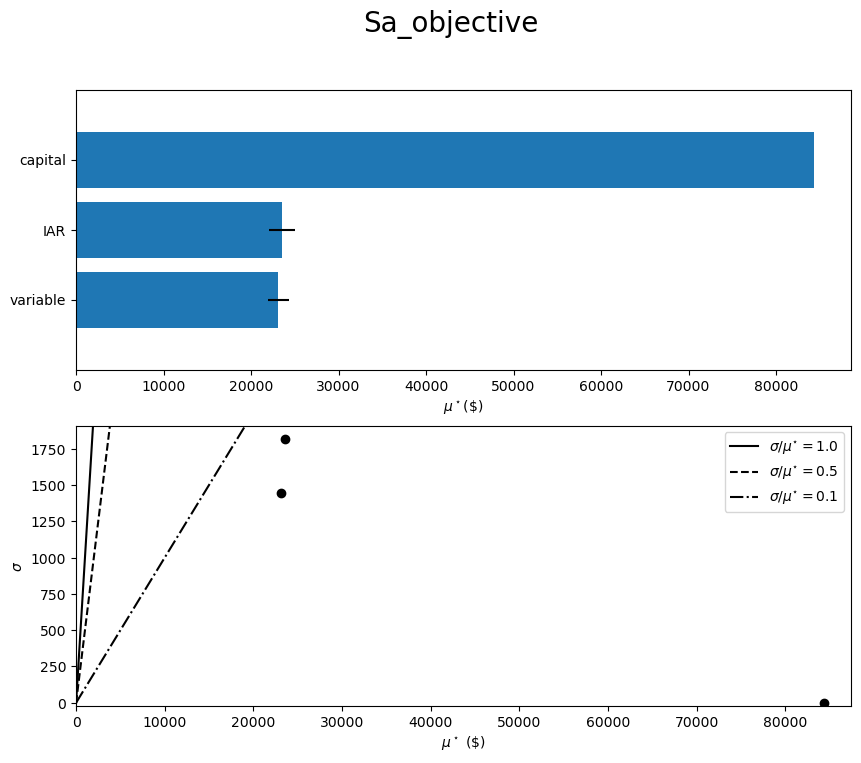

In [53]:
display.Image("./results/0_summary/SA_objective.png")

### Interpreting Results

Capital cost is the most influential factor, of the ones tested, on the total discounted cost of the system. There is no interaction between capital costs and variable costs or input activity ratio. Variable costs and the input activity ratio have non-linear effects and/or interact with each other. 

# Example Three

In this example, it's now up to you to modify the sensitivity parameters ! 

## Reference Energy System

Our RES and included parameters will remain the same. 

![RES](./examples/figures/res.jpg)

### Modify the Configuration File

Navigate to [`examples/3/parameters.csv`](./examples/3/parameters.csv) file and add sensitivity parameters. The available parameters to explore are shown below. Modify the configuration file values however you want ! 

|name |group|indexes|min_value_base_year|max_value_base_year|min_value_end_year|max_value_end_year|dist|interpolation_index|action|
|-----|-----|-------|-------------------|-------------------|------------------|------------------|----|-------------------|------|
|CapitalCost           |capital  |"R1,NUCLEAR"                |XXX |XXX |XXX |XXX |"unif" |"YEAR" |"interpolate" |
|FixedCost             |fixed    |"R1,NUCLEAR"                |XXX |XXX |XXX |XXX |"unif" |"YEAR" |"interpolate" |
|VariableCost          |variable |"R1,MINE_URANIUM,1"         |XXX |XXX |XXX |XXX |"unif" |"YEAR" |"interpolate" |
|SpecifiedAnnualDemand |demand   |"R1,ELECTRICITY"            |XXX |XXX |XXX |XXX |"unif" |"YEAR" |"interpolate" |
|InputActivityRatio    |iar      |"R1,NUCLEAR,URANIUM,1"      |XXX |XXX |XXX |XXX |"unif" |"YEAR" |"interpolate" |
|OperationalLife       |oplife   |"R1,NUCLEAR"                |XXX |XXX |XXX |XXX |"unif" |"YEAR" |"fixed" |

### Run the Workflow

In [54]:
!cp -r ./examples/1/data ./examples/3/data

In [56]:
!snakemake clean --cores 1 --configfile examples/3/config.yaml --quiet

Config file config/config.yaml is extended by additional config specified via the command line.
Building DAG of jobs...
Using shell: /usr/bin/bash
Provided cores: 1 (use --cores to define parallelism)
Rules claiming more threads will be scaled down.
Conda environments: ignored
Singularity containers: ignored
Job stats:
job      count
-----  -------
clean        1
total        1

Checking user inputs...
Select jobs to execute...
Complete log: .snakemake/log/2023-11-06T152521.554887.snakemake.log
Workflow finished successfully!


In [57]:
!snakemake --cores 1 --configfile examples/3/config.yaml --quiet

Config file config/config.yaml is extended by additional config specified via the command line.
Building DAG of jobs...
Using shell: /usr/bin/bash
Provided cores: 1 (use --cores to define parallelism)
Rules claiming more threads will be scaled down.
Conda environments: ignored
Singularity containers: ignored
Job stats:
job                       count
----------------------  -------
all                           1
calculate_SA_objective        1
copy_otoole_config           30
create_model_data            30
create_sample                 1
expand_sample                 1
generate_datafile            30
generate_lp_file             30
get_objective_value           1
get_statistics               30
modify_model_file            30
process_solution             30
solve_lp                     30
unzip_lp                     30
unzip_solution               30
total                       305

Checking user inputs...
Select jobs to execute...
Select jobs to execute...
Select jobs to execute...


### View Results

In [58]:
pd.read_csv("./results/0_summary/SA_objective.csv", index_col=0)

,mu,mu_star,sigma,mu_star_conf
capital,48674.957013,104356.718938,NaN,17450.397399
variable,36141.176732,36141.176732,6787.004027,4903.006163
demand,334097.304346,334097.304346,26248.954035,20083.412295
iar,30863.044465,30863.044465,6001.587705,5091.015315
oplife,-34207.682296,34207.682296,16237.170938,10843.203177


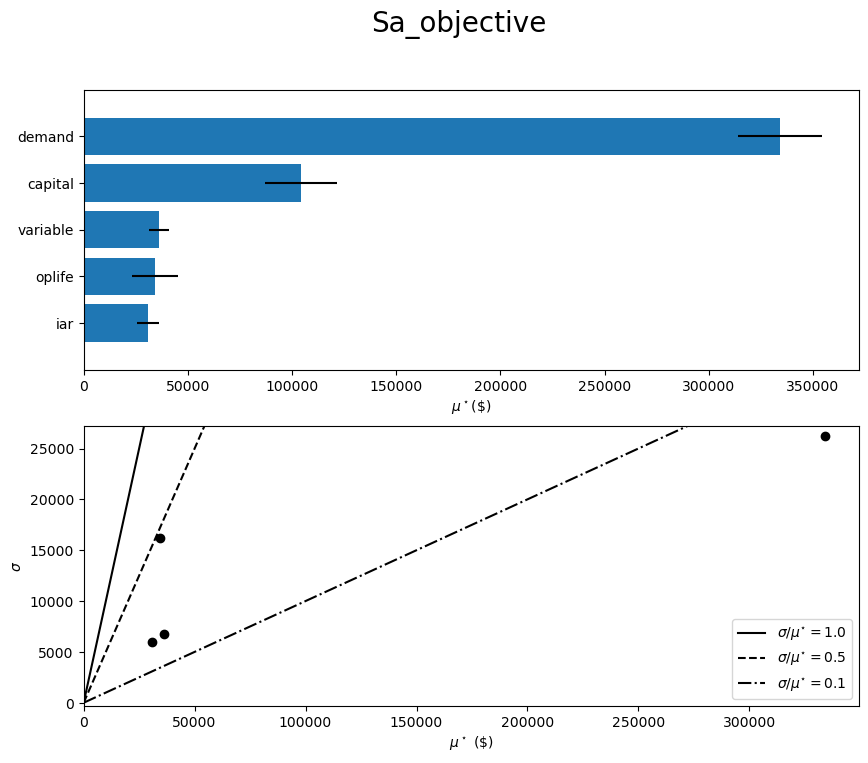

In [59]:
display.Image("./results/0_summary/SA_objective.png")

# Summary 

In this tutorial we have explored how global sensitivity analysis can be applied to very simple energy system optimization model. We applied the Method of Morris to identify influential parameters and parameters that have non-linear and/or interaction with other parameters. In comparison to local sensitivity analysis, global sensitivity analysis allows us explore a wide array of the solution space and identify the important factors. 

During this tutorial, we looked at the sensitivity of one out, total discounted system cost, but we can perform sensitivity analysis for any model output variable of interest. For example, installed capacity, emissions or production. 

We used the Method of Morris to conduct the sensitivity analysis as it allows us to extract sufficient preliminary information with minimal model runs. This is beneficial as energy system optimization models can often have multi-hour run times. Other variance based global sensitivity methods, including those provided by the Python library SALib, can provide more information into the behaviour of the model, with the caveat that this often requires more model runs.

For more detail on the methods presented in this notebook, plese see the following publication: 

> Usher W, Barnes T, Moksnes N and Niet T. Global sensitivity analysis to enhance the transparency and rigour of energy system optimisation modelling [version 1; peer review: 1 approved, 2 approved with reservations]. Open Res Europe 2023, 3:30 (https://doi.org/10.12688/openreseurope.15461.1)